# Introdução

Nesta aula, veremos como utilizar o Variational Quantum Eigensolver (VQE) para obter uma estimativa da energia do estado fundamental de uma molécula. Especificamente, consideraremos aqui a molécula de hidrogênio ($H_2$).

O VQE é uma aplicação dos algoritmos quânticos variacionais (VQAs), que consistem na implementação do método variacional em computação quântica, voltado para uma classe específica de problemas — neste caso, a estimativa da energia do estado fundamental.

Seu funcionamento é, portanto, semelhante ao dos VQAs em geral: trata-se de um método iterativo no qual um otimizador clássico é utilizado para ajustar os parâmetros de um circuito quântico — que gera um estado teste $|\psi_{\pmb{\theta}}\rangle$ — de forma a minimizar uma função de custo, como ilustrado na figura a seguir.


<img src="vqaIlustracao.png" width="900px">
Fonte: https://doi.org/10.1103/RevModPhys.94.015004

Para entendermos como o VQE é utilizado na resolução desta tarefa, adotaremos uma abordagem inversa. Ou seja, em vez de iniciarmos com a parte teórica para, em seguida, passarmos à prática, começaremos pela prática e, depois, analisaremos em detalhes o que está acontecendo em cada etapa.

Assim, a seguir, apresentamos o código utilizado para estimar o menor valor médio de energia da molécula de hidrogênio.

# Código principal

**Primeiramente**, neste momento, **vamos apenas executar o código** e observar o que acontece. Em seguida, analisaremos cada parte do código para entender seu funcionamento e propósito.

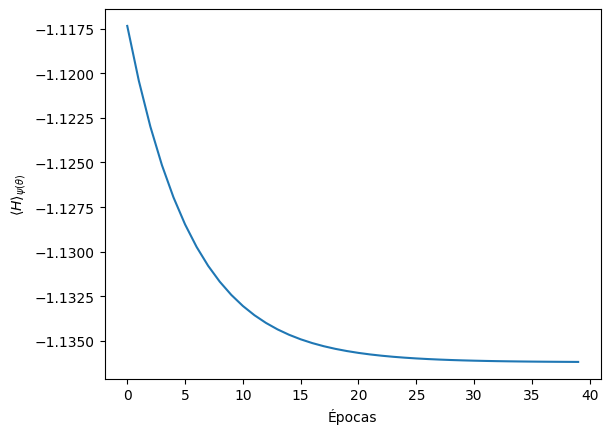

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

symbols = ["H", "H"]
x = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, x)


electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)


def circuit(theta, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(theta, wires=[0, 1, 2, 3])
    
    
dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev)
def cost_fn(theta):
    circuit(theta, wires=range(qubits))
    return qml.expval(H)


epocas = 40
opt = qml.GradientDescentOptimizer(stepsize=0.1)
theta = np.array(0.)
energia = []
for n in range(epocas):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)
    energia.append(prev_energy.item())

    
y = np.array(energia)
x = np.arange(len(y))

n = len(y)

plt.plot(x,y)
plt.ylabel(r'$\langle H \rangle_{\psi(\theta)}$')
plt.xlabel('Épocas')
plt.show()

Este gráfico mostra o comportamento do valor médio $\langle H \rangle_{\psi(\theta)}$, considerando uma função teste $|\psi(\theta)\rangle$, ao longo do treinamento. Como podemos observar, esse valor médio inicia em aproximadamente $-1{,}1175$ e, à medida que o treinamento é realizado — ou seja, à medida que o parâmetro $\theta$ é otimizado —, o valor médio diminui.

Esse comportamento de decaimento indica que o código está funcionando corretamente, pois é exatamente esse o objetivo: minimizar o valor médio da energia.

# Vejamos o que está acontecendo, passo a passo.

A seguir, veremos, passo a passo, o que está acontecendo no código utilizado para obter o menor valor médio $\langle H \rangle_{\psi(\theta)}$.


## 1 - Preparação do Hamiltoniano

Quando usamos o VQE para estudar uma molécula, nossa primeira tarefa é obter o Hamiltoniano molecular que a descreve. No caso da molécula de hidrogênio, sabemos que o Hamiltoniano é dado por:

$$
H = - \frac{\hbar^2}{2m_e}\big( \nabla_{1}^2 + \nabla_{2}^2 \big) - ke^2 \bigg( \frac{1}{r_1} + \frac{1}{r_2} + \frac{1}{r_1'} + \frac{1}{r_2'} - \frac{1}{r_{12}} - \frac{1}{R} \bigg). \tag{1}
$$

Todavia, ao utilizarmos o VQE para estudar o $H_2$, devemos empregar o Hamiltoniano na formulação da **segunda quantização**  [1](https://en.wikipedia.org/wiki/Second_quantization). Nessa formulação, o Hamiltoniano de uma molécula é dado por:

$$
H(\pmb{x}) = \sum_{pq}h_{pq}(\pmb{x})C_{p}^{\dagger}C_{q} + \frac{1}{2} \sum_{pqrs}h_{pqrs}(\pmb{x})C_{p}^{\dagger}C_{q}^{\dagger}C_rC_s, \tag{2}
$$
onde $\pmb{x}$ representa os parâmetros que descrevem a geometria da molécula, e os índices da soma na Eq. (2) são definidos com base em orbitais moleculares calculados segundo a aproximação de Hartree-Fock. Os operadores $C_{j}^{\dagger}$ e $C_{j}$ são, respectivamente, os operadores de criação e aniquilação, e obedecem às seguintes relações de anticomutação:
$$
\{ C_{j}, C_{j'}^{\dagger} \} = \delta_{j,j'} \tag{3}
$$
e

$$
\{ C_{j}, C_{j'} \} = 0 \tag{4}.
$$


Porém, não basta obtermos o Hamiltoniano descrito pela Eq. [2]. Na verdade, após essa etapa, é necessário transformá-lo em uma forma que um computador quântico seja capaz de processar. Existem diversas maneiras de realizar essa conversão, mas uma das mais utilizadas é por meio da **Transformação de Jordan-Wigner**.

Essa transformação permite expressar os operadores de criação ($C_{j}^{\dagger}$) e aniquilação ($C_{j}$) em termos dos operadores (ou matrizes) de Pauli $\{I, \sigma_{x}, \sigma_{y}, \sigma_{z}\}$, de modo que:


$$
C_{j}^{\dagger} \Leftrightarrow \sigma_{z}^{\otimes (j-1)} \otimes \sigma^{-} \otimes I^{\otimes(N-j)}\tag{5}
$$

e

$$
C_{j} \Leftrightarrow \sigma_{z}^{\otimes (j-1)} \otimes \sigma^{+} \otimes I^{\otimes(N-j)},\tag{6}
$$

onde

$$
\sigma^{+} \equiv \frac{ \sigma_x + i \sigma_y }{2} \quad \text{e} \quad \sigma^{-} \equiv \frac{ \sigma_x - i \sigma_y }{2}.\tag{7}
$$


Após essa transformação, obteremos um Hamiltoniano na seguinte forma:

$$
H(\pmb{x}) = \sum_{j}h_{j}(\pmb{x})P_j,\tag{8}
$$
onde $P_j$ são as *Pauli strings* — produtos de todas as combinações possíveis dos operadores de Pauli — e $h_{j}(\pmb{x})$ são coeficientes que dependem das coordenadas $\pmb{x}$ e que ponderam a relevância de cada Pauli string.

Dessa forma, obtemos um Hamiltoniano que pode ser processado por um computador quântico.

**Mas como isso é feito no código acima?** Todo esse processo descrito até agora é realizado pelo seguinte trecho de código:

In [3]:
symbols = ["H", "H"] # Aqui definimos que tipo de molecula iremos tratar
x = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])#As coordenadas dos átomos da molecula

# cria o Hamiltoniano e também retorna o número de qubits necessários para isso
H, qubits = qml.qchem.molecular_hamiltonian(symbols, x)

Ou seja, para obtermos o Hamiltoniano, basta definirmos o tipo de molécula que queremos analisar — neste caso, feito com ``symbols = ["H", "H"]`` — e as coordenadas dos átomos dessa molécula, que, neste exemplo, são dadas por ``x = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])``.

Com isso, todo o processo necessário para obter o Hamiltoniano na forma apresentada na Eq. [8] é realizado automaticamente pela função ``H, qubits = qml.qchem.molecular_hamiltonian(symbols, x)``.


In [4]:
print(H)

  (-0.2427450126094144) [Z2]
+ (-0.2427450126094144) [Z3]
+ (-0.042072551947439224) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299361) [Z0 Z2]
+ (0.12293330449299361) [Z1 Z3]
+ (0.16768338855601356) [Z0 Z3]
+ (0.16768338855601356) [Z1 Z2]
+ (0.17059759276836803) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.044750084063019925) [Y0 Y1 X2 X3]
+ (-0.044750084063019925) [X0 X1 Y2 Y3]
+ (0.044750084063019925) [Y0 X1 X2 Y3]
+ (0.044750084063019925) [X0 Y1 Y2 X3]


Acima, imprimimos o Hamiltoniano para a molécula de $H_2$, considerando as coordenadas definidas anteriormente. Neste contexto, a letra indica qual matriz de Pauli está sendo utilizada, e o número corresponde ao índice do qubit onde essa matriz atua.

Mais informações sobre a preparação do Hamiltoniano podem ser encontradas na referência [2]( https://arxiv.org/html/2505.04768v1).


## 2 - Preparação do estado inicial

Por padrão, todos os qubits de um algoritmo quântico iniciam no estado $|0\rangle$. Em outras palavras, nosso estado inicial é $|0\rangle^{\otimes N}$. Portanto, após obtermos o Hamiltoniano que descreve a molécula de interesse, a próxima etapa é preparar o estado inicial. Para isso, precisamos saber quantos qubits serão necessários para trabalhar com a molécula em questão.

Assim como o Hamiltoniano é obtido automaticamente pelo Pennylane — bastando informar a molécula e as coordenadas dos átomos —, o número de qubits necessários também é retornado pela função ``H, qubits = qml.qchem.molecular_hamiltonian(symbols, x)``. Para mais detalhes sobre como esse número é calculado, uma possível referência é [2]( https://arxiv.org/html/2505.04768v1).

No caso do $H_2$, são necessários 4 qubits. Assim, nosso estado inicial do algoritmo será $|0000\rangle$. É importante **observar** que, embora este seja o **estado inicial do algoritmo quântico**, ele **não corresponde ao estado inicial que representa a molécula** em estudo.

Na verdade, o estado inicial que descreve a molécula em análise é construído da seguinte forma: considere uma molécula com $k$ elétrons, para a qual são necessários $n$ qubits. O estado inicial é obtido colocando os $k$ primeiros qubits no estado $|1\rangle$ e os demais $n-k$ qubits no estado $|0\rangle$.

Ou seja, para o caso da molécula $H_2$, que possui 2 elétrons e requer 4 qubits, o estado inicial será dado por:


$$
|\psi_1\rangle = |1100\rangle.\tag{9}
$$

Este estado inicial é chamado de **estado de Hartree-Fock**, pois ele é derivado do **método de Hartree-Fock**, um método aproximado amplamente utilizado para resolver o mesmo problema que o VQE busca resolver: a determinação do estado fundamental de uma molécula.


- Para reforçar essa ideia, considere que, em vez de estudarmos o $H_2$, analisemos o íon $H_2^{+}$. Nesse caso, também precisaríamos de 4 qubits, porém, como há apenas um elétron, o estado inicial seria $|\psi_1\rangle = |1000\rangle$.


No nosso código principal, isso é feito no seguinte trecho:

In [5]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)

Na verdade, o que esse trecho do código faz é obter o rótulo do nosso estado inicial, que, no caso da Eq. [9], corresponde à sequência ``1100``, como pode ser observado ao imprimir ``hf`` abaixo.

In [6]:
hf

tensor([1, 1, 0, 0], requires_grad=True)

Esse rótulo, por sua vez, é passado para a função ``def circuit(param, wires)``, que a partir dele cria o estado inicial descrito na Eq. [9], utilizando a seguinte linha de comando: ``qml.BasisState(hf, wires=wires)``.


## 3 - Parametrização  

Agora que temos nosso estado inicial, descrito pela Eq. [9], precisamos construir a parametrização $U(\pmb{\theta})$, tal que:

$$
|\psi\rangle = U(\pmb{\theta})|\psi_1\rangle =  U(\pmb{\theta})|1100\rangle.\tag{10}
$$

A princípio, a parametrização $U(\pmb{\theta})$ pode assumir qualquer forma, ou seja, a escolha das portas lógicas quânticas usadas e sua ordem é livre. Por exemplo, ao trabalharmos com VQAs, é muito comum definirmos essa parametrização da seguinte forma:

$$
U(\pmb{\theta}) = \prod_{i=1}^{L}U_{i}(\pmb{\theta}_i),\tag{11}
$$
onde $U_{i}(\pmb{\theta}_i)$ são chamadas de camadas, e elas são construídas a partir de um conjunto de portas lógicas quânticas — sendo que todas as camadas utilizam o mesmo conjunto, com a única diferença nos parâmetros $\pmb{\theta}_i$ aplicados em cada uma. Na figura abaixo, mostramos alguns exemplos de como essas camadas podem ser construídas.


<img src="U_exemplo.png" width="1000px">

Porém, um **problema** com a forma de obtermos $U(\pmb{\theta})$ usando a Eq. [11] é que, independentemente do estado inicial $|\psi_1\rangle$, o estado evoluído $|\psi\rangle$ terá a seguinte forma:

$$
|\psi \rangle = \sum_{j_0,j_1,...,j_n=0}^1\alpha_{j_0,j_1,...,j_n}|j_0,j_1,...,j_n\rangle.\tag{12}
$$

Por exemplo, para um algoritmo com quatro qubits, teremos o seguinte estado evoluído:

$$
|\psi \rangle = \alpha_0|0000\rangle + \alpha_1|0001\rangle + \alpha_2|0010\rangle + \alpha_3|0011\rangle + \alpha_4|0100\rangle + \alpha_5|0101\rangle + \alpha_6|0110\rangle + \alpha_7|0111\rangle +  ... \tag{13}
$$

**Mas qual é o problema com isso?**

Quando usamos o VQE, os elétrons da molécula em análise são mapeados para os qubits de modo que, para cada elétron da molécula, um qubit seja colocado no estado $|1\rangle$. Por exemplo, a seguir são apresentados alguns estados e o número de elétrons que cada um representa:

$$
|1000\rangle \longrightarrow \text{1 elétron}, \quad |0010\rangle \longrightarrow \text{1 elétron}, \quad |1001\rangle \longrightarrow \text{2 elétrons},  \quad |1101\rangle \longrightarrow \text{3 elétrons}, \quad |1111\rangle \longrightarrow \text{4 elétrons}. 
$$











Portanto, como estamos usando o VQE para analisar uma molécula cujo **número de elétrons não varia**, precisamos garantir que o estado evoluído represente exatamente esse número de elétrons.

Assim, para o $H_2$, não podemos utilizar uma parametrização que leve ao estado evoluído descrito pela Eq. [12], pois esse estado contém autovetores inválidos — ou seja, que não correspondem ao número correto de elétrons. Especificamente, os seguintes autovetores são problemáticos:

$$
|\psi \rangle = \color{red}{\alpha_0|0000\rangle} + \color{red}{\alpha_1|0001\rangle} + \color{red}{\alpha_2|0010\rangle} + \alpha_3|0011\rangle + \color{red}{\alpha_4|0100\rangle} + \alpha_5|0101\rangle + \alpha_6|0110\rangle + \color{red}{\alpha_7|0111\rangle} +  ... \tag{14}
$$

**Então, como construímos $U(\pmb{\theta})$?**

A princípio, qualquer forma que preserve o número de elétrons é válida. Ou seja, dado um $U(\pmb{\theta})$, se todos os autovetores do estado evoluído mantêm o número de elétrons preservado, então $U(\pmb{\theta})$ é válido. Contudo, algumas formas são mais utilizadas ao lidarmos com esse tipo de problema. Especificamente, usam-se as chamadas **Rotações de Givens**, que consistem em operações que preservam o número de elétrons.

No Pennylane, existem duas funções 'primitivas' usadas para construir parametrizações que preservam o número de elétrons, são elas:


- `` SingleExcitation``: Esta é uma operação que atua em dois qubits de modo que:

$$
G|01\rangle = a|01\rangle+b|10\rangle, \tag{15}
$$

$$
G|10\rangle = c|10\rangle+d|01\rangle, \tag{16}
$$

onde

$$
G = G(\theta) = \begin{bmatrix}
1 & 0 & 0 & 0  \\
0 & \cos(\theta/2) & -\sin(\theta/2) & 0 \\
0 & \sin(\theta/2) & \cos(\theta/2) & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} \tag{17}
$$

- ``DoubleExcitation``: Esta é uma operação que atua em quatro qubits de modo que:

$$
G^{(2)}|0011\rangle = \cos(\theta/2)|0011\rangle + \sin(\theta/2)|1100\rangle, \tag{18}
$$

$$
G^{(2)}|1100\rangle = \cos(\theta/2)|1100\rangle - \sin(\theta/2)|0011\rangle. \tag{19}
$$

Para mais informações veja: https://pennylane.ai/qml/demos/tutorial_givens_rotations. 

Voltando ao nosso código principal, a construção da parametrização é feita dentro da função ``def circuit(param, wires)``, onde aplicamos especificamente as transformações descritas nas Eqs. [18] e [19]. Isso é realizado por meio da seguinte linha de comando: ``qml.DoubleExcitation(param, wires=[0, 1, 2, 3])``.

Como nosso estado inicial é dado pela Eq. [9], ao aplicarmos a transformação $G^{(2)}$, o estado evoluído que obteremos será o descrito na Eq. [19].

Usando a notação de circuito para visualizar nosso algoritmo, temos o seguinte:

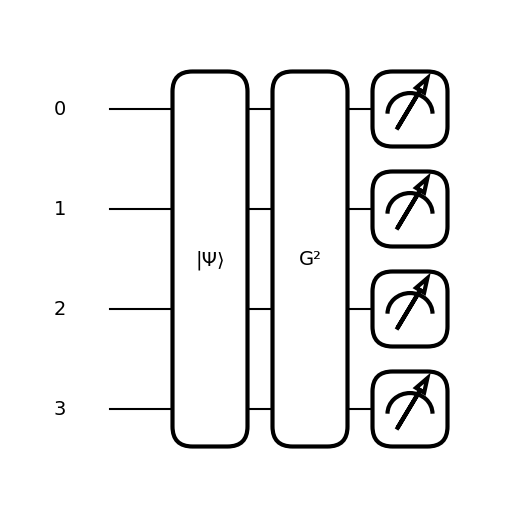

In [7]:
fig, ax = qml.draw_mpl(cost_fn)(1)
plt.show()

**OBS**: Quando criamos um algoritmo quântico e o executamos em um computador quântico real, a primeira etapa é a transpilação. Isso significa que o circuito do nosso algoritmo será reescrito para utilizar apenas o conjunto de portas lógicas quânticas que o computador consegue implementar. Em geral, esse conjunto depende do computador quântico específico, pois diferentes computadores utilizam conjuntos distintos.

Todavia, é comum que esse conjunto inclua portas de rotação e CNOT.

A seguir, mostramos como esse circuito fica em termos de portas fundamentais, especificamente as portas de rotação, CNOT e X.

<img src="circuitoDecomposto2.png" width="1400px">

-------------

**Uma observação muito importante** sobre a escolha de $U$ diz respeito à sua **expressividade**. A expressividade está associada ao número de estados distintos que conseguimos gerar usando $U$. Quanto maior esse número, mais expressivo é $U$.

**Por que isso é importante?**

Nossa principal tarefa ao usarmos um VQE é encontrar o estado $|\psi\rangle$ que minimiza o valor médio $\langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle$. Porém, não sabemos a priori qual é esse estado $|\psi\rangle$. Em outras palavras, precisamos escolher $U$ o mais expressivo possível, pois assim, mesmo sem sabermos exatamente qual estado $|\psi\rangle$ deve ser gerado, sabemos que $U$ é capaz de gerá-lo.

A figura a seguir mostra, de forma clara, a relação entre a parametrização $U$ escolhida e sua expressividade.
a) Apresenta quatro diferentes circuitos de um qubit, cada um obtido usando um conjunto distinto de portas lógicas quânticas.
b) Mostra a representação na **esfera de Bloch** dos estados que cada circuito pode gerar. Cada estado é representado por um ponto roxo.


<img src="expressividade.png" width="1000px">
Fonte:  	
https://doi.org/10.1002/qute.201900070

Como a figura acima mostra, dependendo da escolha de $U$, o número de estados uniformemente gerados varia. Para parametrizações com maior expressividade, mais estados são gerados de forma uniforme.

---

No nosso caso, em que temos um circuito com quatro qubits e dois elétrons, a parametrização $U$ mais geral possível é aquela que transforma nosso estado inicial $|\psi_1\rangle$, descrito pela Eq. [9], em um estado do tipo


$$
|\psi \rangle = \alpha_1 |0011\rangle + \alpha_2 |0101\rangle + \alpha_3|0110\rangle + \alpha_4 |1001\rangle + \alpha_5 |1010\rangle + \alpha_6 |1100\rangle \tag{20},
$$
pois assim poderemos gerar todos os estados possíveis, considerando a restrição de que o número de qubits no estado $|1\rangle$ deve ser igual ao número de elétrons da molécula.

Isso é feito com o seguinte código:

In [8]:
dev = qml.device('default.qubit',wires=4)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param[0], wires=[0, 1, 2, 3])
    qml.SingleExcitation(param[1],wires=[0,2])
    qml.SingleExcitation(param[2],wires=[0,3])
    
    
dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.state()


In [9]:
param = np.random.random(3) # gera param aleatorios
output = cost_fn(param) # executa a função cost_fn e retorna o estado |\psi>

# o código a seguir imprime o rótulo dos autovetores do estado |\psi> 
states = [np.binary_repr(i, width=4) for i in range(len(output)) if output[i] != 0] 
print(states)


['0011', '0101', '0110', '1001', '1010', '1100']


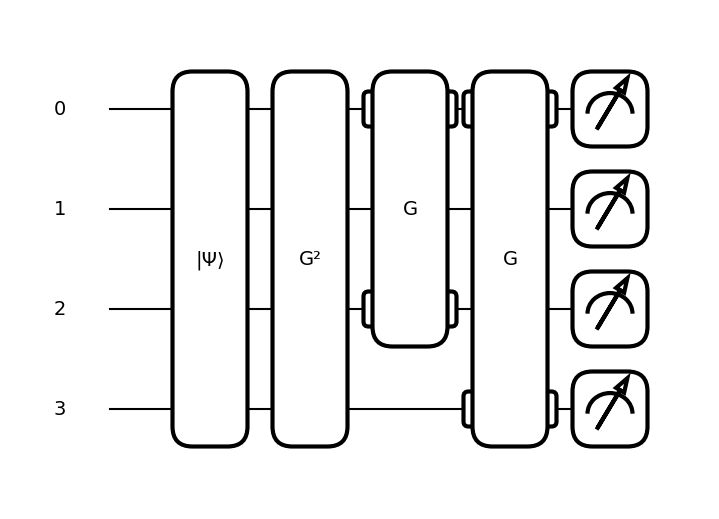

In [10]:
fig, ax = qml.draw_mpl(cost_fn)(param)
plt.show()

**OBS**: Apesar de a parametrização usada por este circuito ser mais expressiva do que a utilizada no código principal, aqui iremos considerar, por questões didáticas, a do código principal. Porém, um bom **exercício** é realizar as simulações utilizando essa parametrização mais expressiva.

## 4 - Otimização

Definidos o estado inicial $|\psi_1 \rangle$ e a parametrização $U$, tal que o estado evoluído $|\psi\rangle$ é descrito pela Eq. [10], devemos agora realizar as medições. Nesse caso, as medições consistem no cálculo do valor médio do Hamiltoniano descrito pela Eq. [8]. Isso é feito pela linha de comando ``return qml.expval(H)`` dentro da função ``cost_fn`` do nosso código principal.

Ao realizarmos essa medição, obtemos o valor médio do Hamiltoniano. Porém, como o parâmetro $\theta$ é inicialmente escolhido de forma “ingênua”, o valor médio calculado será diferente do valor mínimo desejado. Portanto, é necessário otimizar o parâmetro $\theta$ para minimizar esse valor médio.

Diversos métodos podem ser usados para essa otimização. Todavia, o mais comum é o método conhecido como **gradiente descendente**, que consiste em utilizar o gradiente do valor médio $\langle H \rangle_{\psi_{\theta}}$ — calculado pelo algoritmo quântico — para atualizar os parâmetros $\theta$. Para isso, usamos a seguinte regra de otimização:

$$
\theta_{t+1} = \theta_{t} - \eta \nabla_{\theta_{t}}\langle H \rangle_{\psi_{\theta_t}}. \tag{21}
$$


No nosso código principal, esse processo de otimização é realizado pelo seguinte trecho do código:

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
theta = np.array(0.)
energia = []
for n in range(epocas):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)
    energia.append(prev_energy.item())


## 5 - Valor médio em função da distância interatômica

Nosso código principal é usado para calcular a menor energia média $\langle H \rangle$ dada uma distância entre os núcleos atômicos. Portanto, para cada distância, usamos o mesmo código para calcular o menor valor de $\langle H \rangle$. O código a seguir utiliza nosso código principal para calcular o menor valor de $\langle H \rangle$ para diferentes distâncias $R$.

In [21]:
# Criamos um array R que representa várias distâncias entre os dois átomos de hidrogênio
R = np.arange(0, 6, 0.1)

# Lista para armazenar os valores mínimos de energia obtidos para cada distância R
dataHist = []

# Loop para calcular a energia do sistema em diferentes distâncias entre os átomos
for k in range(len(R)):
    # Pegamos a distância atual e arredondamos para 3 casas decimais para exibição
    dd = round(R[k].item(), 3)
    print('\n Distância R = {} '.format(dd))

    # Definimos os símbolos dos átomos que compõem a molécula (aqui dois átomos de hidrogênio)
    symbols = ["H", "H"]

    # Definimos a posição dos átomos no espaço 3D, aqui o segundo átomo está a distância R[k] no eixo z
    x = np.array([[0.0, 0.0, 0], [0.0, 0.0, R[k]]])

    # Calculamos o Hamiltoniano molecular (energia total do sistema em função dos qubits)
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, x)

    # Número total de elétrons na molécula (H2 tem 2 elétrons)
    electrons = 2

    # Criamos o estado de Hartree-Fock (estado inicial aproximado) para o sistema
    hf = qml.qchem.hf_state(electrons, qubits)

    # Definimos o circuito quântico parametrizado que vamos otimizar
    def circuit(theta, wires):
        # Inicializamos o circuito no estado de Hartree-Fock
        qml.BasisState(hf, wires=wires)
        # Aplicamos uma porta de dupla excitação parametrizada pelo ângulo theta
        qml.DoubleExcitation(theta, wires=[0, 1, 2, 3])

    # Criamos o dispositivo quântico simulado para executar o circuito (com número de qubits calculado)
    dev = qml.device("default.qubit", wires=qubits)

    # Definimos uma função quântica (QNode) que calcula o valor esperado da energia para dado theta
    @qml.qnode(dev)
    def cost_fn(theta):
        # Executa o circuito parametrizado
        circuit(theta, wires=range(qubits))
        # Retorna o valor esperado do Hamiltoniano, que é a energia do sistema para o theta atual
        return qml.expval(H)

    # Número de épocas para o algoritmo de otimização (quantas vezes o parâmetro será ajustado)
    epocas = 40

    # Inicializamos o otimizador do gradiente com \eta = 0.1
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    # Inicializamos o parâmetro theta (ângulo da porta de excitação) com zero. Aqui poderiamos usar outro valor.
    theta = np.array(0.)

    # Lista para guardar os valores de energia em cada época de otimização
    energia = []

    # Loop de otimização para ajustar theta e minimizar a energia
    for n in range(epocas):
        # Atualiza theta para tentar reduzir a energia; prev_energy é a energia antes da atualização
        theta, prev_energy = opt.step_and_cost(cost_fn, theta)
        # Guarda o valor da energia atual na lista
        energia.append(prev_energy.item())

    # Após otimizar, pegamos a energia mínima encontrada e armazenamos em dataHist
    dataHist.append(np.min(energia))



 Distância R = 0.0 

 Distância R = 0.1 

 Distância R = 0.2 

 Distância R = 0.3 

 Distância R = 0.4 

 Distância R = 0.5 

 Distância R = 0.6 

 Distância R = 0.7 

 Distância R = 0.8 

 Distância R = 0.9 

 Distância R = 1.0 

 Distância R = 1.1 

 Distância R = 1.2 

 Distância R = 1.3 

 Distância R = 1.4 

 Distância R = 1.5 

 Distância R = 1.6 

 Distância R = 1.7 

 Distância R = 1.8 

 Distância R = 1.9 

 Distância R = 2.0 

 Distância R = 2.1 

 Distância R = 2.2 

 Distância R = 2.3 

 Distância R = 2.4 

 Distância R = 2.5 

 Distância R = 2.6 

 Distância R = 2.7 

 Distância R = 2.8 

 Distância R = 2.9 

 Distância R = 3.0 

 Distância R = 3.1 

 Distância R = 3.2 

 Distância R = 3.3 

 Distância R = 3.4 

 Distância R = 3.5 

 Distância R = 3.6 

 Distância R = 3.7 

 Distância R = 3.8 

 Distância R = 3.9 

 Distância R = 4.0 

 Distância R = 4.1 

 Distância R = 4.2 

 Distância R = 4.3 

 Distância R = 4.4 

 Distância R = 4.5 

 Distância R = 4.6 

 Distância R

A seguir, imprimimos o gráfico do menor valor de $\langle H \rangle$ para cada valor de $R$ considerado.

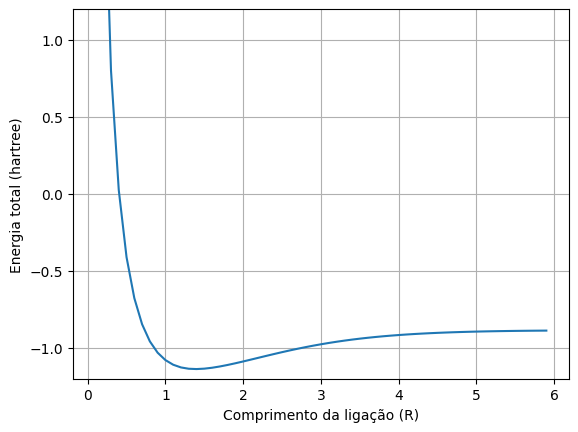

In [23]:
y = np.array(dataHist)
plt.plot(R,y)
plt.ylim(-1.2,1.2)
plt.grid()
plt.xlabel('Comprimento da ligação (R)')
plt.ylabel('Energia total (hartree)')
plt.show()

Este gráfico está de acordo com o esperado. Ou seja, para $R \longrightarrow 0$, temos que $\langle H \rangle \longrightarrow \infty$ devido à energia potencial de repulsão entre os átomos. Para $R \longrightarrow \infty$, $\langle H \rangle$ tende a uma constante, pois os dois átomos estarão suficientemente separados e não mais interagirão, comportando-se como dois átomos de hidrogênio isolados. Já para $R \approx 1.4$, observamos a menor energia média, indicando o ponto de equilíbrio da molécula de hidrogênio.